In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 81.2MB/s 
     |████████████████████████████████| 460kB 50.7MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!wget "https://drive.google.com/uc?export=download&id=1ByJN0Vh4ctIwNdnO2jevEcBgrbRHuNyM" -O "ratings_train.txt"
!wget "https://drive.google.com/uc?export=download&id=1fNm-8pQJsuDbFaVIMow1DI-7lsnNLRFB" -O "ratings_test.txt"

--2020-11-07 13:20:25--  https://drive.google.com/uc?export=download&id=1ByJN0Vh4ctIwNdnO2jevEcBgrbRHuNyM
Resolving drive.google.com (drive.google.com)... 108.177.127.101, 108.177.127.100, 108.177.127.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7b4jt7q2a4bf18vnn5lqmgrs0ev3stoj/1604755200000/13472183013488020071/*/1ByJN0Vh4ctIwNdnO2jevEcBgrbRHuNyM?e=download [following]
--2020-11-07 13:20:26--  https://doc-0o-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7b4jt7q2a4bf18vnn5lqmgrs0ev3stoj/1604755200000/13472183013488020071/*/1ByJN0Vh4ctIwNdnO2jevEcBgrbRHuNyM?e=download
Resolving doc-0o-94-docs.googleusercontent.com (doc-0o-94-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to doc-0o-94-docs.googleusercontent.com (do

In [4]:
# pandas 이용 train, test 데이터 로드

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
train_data.head()

,Unnamed: 0,id,document,label
0,0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,2,10265843,너무재밓었다그래서보는것을추천한다,0
3,3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [9]:
from konlpy.tag import Okt

In [10]:
okt = Okt()

In [11]:
x_train = [ okt.morphs(sentence) for sentence in train_data['document'] ]

In [12]:
x_test = [ okt.morphs(sentence) for sentence in test_data['document'] ]

In [13]:
x_train[2]

['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다']

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [16]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [17]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 100022
등장 빈도가 2번 이하인 희귀 단어의 수: 67691
단어 집합에서 희귀 단어의 비율: 67.67611125552378
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.239470223706072


In [18]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 32333


In [19]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(x_train)

In [20]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [21]:
x_train[0]

[55, 436, 19, 6617, 643]

In [22]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [23]:
drop_train_idx = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]

In [24]:
x_train = np.delete(x_train, drop_train_idx, axis=0)
y_train = np.delete(y_train, drop_train_idx, axis=0)

In [25]:
len(x_train), len(y_train)

(145393, 145393)

In [26]:
import matplotlib.pyplot as plt

In [27]:
print('리뷰 최대 길이', max(list(map(lambda x : len(x), x_train))) )
print('리뷰 평균 길이', sum(map(len, x_train)) / len(x_train))

리뷰 최대 길이 78
리뷰 평균 길이 13.102109455063173


Text(0, 0.5, 'number of data')

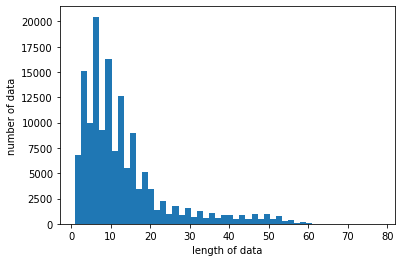

In [28]:
plt.hist([ len(s) for s in x_train ], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')

In [29]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [30]:
below_threshold_len(30, x_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 91.41636805073146


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# pad sequences

x_train = pad_sequences(x_train, maxlen=30)
x_test = pad_sequences(x_test, maxlen=30)

In [32]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Embedding (vocab_size, ???, 30), LSTM(??), Dense(?)

model = Sequential([
  Embedding(vocab_size, 64, input_length=30),
  LSTM(6, kernel_regularizer=regularizers.l2(0.001)),
  Dropout(0.5),
  Dense(1, activation='sigmoid')                         
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            2069312   
_________________________________________________________________
lstm (LSTM)                  (None, 6)                 1704      
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 2,071,023
Trainable params: 2,071,023
Non-trainable params: 0
_________________________________________________________________


In [33]:
# compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
# fit
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
909/909 [==============================] - 19s 21ms/step - loss: 0.4753 - accuracy: 0.8004 - val_loss: 0.3748 - val_accuracy: 0.8419
Epoch 2/10
909/909 [==============================] - 19s 21ms/step - loss: 0.3506 - accuracy: 0.8656 - val_loss: 0.3616 - val_accuracy: 0.8454
Epoch 3/10
909/909 [==============================] - 19s 21ms/step - loss: 0.3034 - accuracy: 0.8867 - val_loss: 0.3635 - val_accuracy: 0.8471
Epoch 4/10
909/909 [==============================] - 19s 20ms/step - loss: 0.2717 - accuracy: 0.8995 - val_loss: 0.3845 - val_accuracy: 0.8452
Epoch 5/10
909/909 [==============================] - 19s 20ms/step - loss: 0.2480 - accuracy: 0.9094 - val_loss: 0.4187 - val_accuracy: 0.8357
Epoch 6/10
909/909 [==============================] - 19s 20ms/step - loss: 0.2285 - accuracy: 0.9173 - val_loss: 0.4513 - val_accuracy: 0.8378
Epoch 7/10
909/909 [==============================] - 19s 21ms/step - loss: 0.2094 - accuracy: 0.9249 - val_loss: 0.4736 - val_accuracy:

In [35]:
# accuracy, val_acc, loss, val_loss <= history 객체에서 추출

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

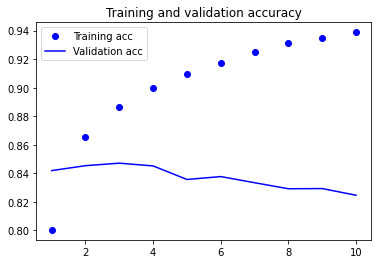

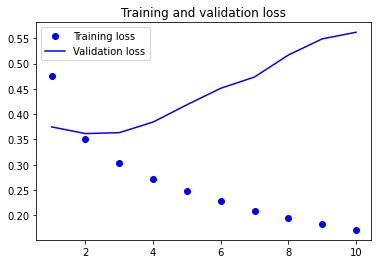

In [37]:
# 위의 값 시각화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [38]:
# evalute 모델 test
model.evaluate(x_test, y_test)

1532/1532 [==============================] - 4s 2ms/step - loss: 0.5654 - accuracy: 0.8209


[0.5654377341270447, 0.8209409117698669]

In [39]:
from konlpy.tag import Okt

def sentiment_predict(sentence):

  new_sentence = Okt().morphs(phrase=sentence, stem=True)

  encoded = tokenizer.texts_to_sequences([new_sentence])
  padded = pad_sequences(encoded, maxlen=30)

  score = float(model.predict(padded))

  if (score > 0.5):
    print( '{:.2f}% 확률로 긍정'.format(score *100))
  else:
    print( '{:.2f}% 확률로 부정'.format((1-score) *100))


In [40]:
sentiment_predict('이 영화 완전 꿀잼')

98.10% 확률로 긍정


In [41]:
sentiment_predict('쓰레기같은 최악의 영화')

99.99% 확률로 부정


In [43]:
sentiment_predict('다시 보고 싶은 영화이다')

95.87% 확률로 긍정
